In [5]:
# Import necessary libraries

from bs4.element import NavigableString
import pandas as pd
import numpy as np
import spacy
import pickle
import requests
from bs4 import BeautifulSoup
import re
import gensim
import random
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# load model MARCA
ES_defs = [["mujer", "hombre"], ["nina", "nino"], ["ella", "él"], ["madre", "padre"], ["hija", "hijo"], ["chica", "chico"], ["femenino", "masculino"], ["hermana", "hermano"], ["maría", "juan"]]
w2v_model = Word2Vec.load(r"C:\Users\marta\OneDrive - Universidad Carlos III de Madrid\documentos\UC3M4\TFG\TFG\.ipynb_checkpoints\models\marca\sportword2vec.model")
PATH_VOCAB = r"C:\Users\marta\OneDrive - Universidad Carlos III de Madrid\documentos\UC3M4\TFG\TFG\.ipynb_checkpoints\models\marca\pipe7-vocab"
# load model AS
#w2v_model = Word2Vec.load(r"C:\Users\marta\OneDrive - Universidad Carlos III de Madrid\documentos\UC3M4\TFG\TFG\.ipynb_checkpoints\models\as\AsWord2Vec.model")
#PATH_VOCAB = r"C:\Users\marta\OneDrive - Universidad Carlos III de Madrid\documentos\UC3M4\TFG\TFG\.ipynb_checkpoints\models\as\As-vocab"
# load model MUNDO DEPOTIVO
#PATH_VOCAB =  r"C:\Users\marta\OneDrive - Universidad Carlos III de Madrid\documentos\UC3M4\TFG\TFG\.ipynb_checkpoints\models\mundoDeportivo\MD-vocab"
#w2v_model = Word2Vec.load(r"C:\Users\marta\OneDrive - Universidad Carlos III de Madrid\documentos\UC3M4\TFG\TFG\.ipynb_checkpoints\models\mundoDeportivo\MDWord2Vec.model")

# Preliminary analysis: PCA

In [6]:
# check similarity, how well do the gender pairs capture GENDER
#gender_pairs = [("ella", "él"),("mujer", "hombre"), ("maría", "josé"), ("hija", "hijo"), ("madre", "padre"), ("nina", "nino"), ("chica", "chico"), ("hembra", "macho")]
ES_defs_trunc = [("ella", "él"),("maría", "josé"), ("mujer", "hombre"), ("madre", "padre"), ("hija", "hijo"), ("femenino", "masculino"), ("hermana", "hermano"), ("nina", "nino"),
                ("chica", "chico")]
'''She_he_classifier returns a list of gender paired words who describe gender by cheking proximity to reference words él y ella'''
def she_he_classifier(gender_pairs):
    pairs_check = []
    for (female_word, male_word) in gender_pairs:
        # compute cosine similarities
        d1 = w2v_model.wv.similarity(female_word, 'ella')
        d2 = w2v_model.wv.similarity(female_word, 'él')
        d3 = w2v_model.wv.similarity(male_word, 'ella')
        d4 = w2v_model.wv.similarity(male_word, 'él')
        if (d1 > d2) and (d3 < d4):
            pairs_check.append((female_word, male_word))
            print("Word "+female_word+" captures gender: "+str(d1)+" "+str(d2))
            print("Word "+male_word+" captures gender: "+str(d2)+" "+str(d1))
    return pairs_check
        
gender_pairs_filtered = she_he_classifier(ES_defs_trunc)

Word ella captures gender: 1.0 0.67664003
Word él captures gender: 0.67664003 1.0
Word maría captures gender: 0.3609152 0.2863059
Word josé captures gender: 0.2863059 0.3609152
Word mujer captures gender: 0.81843215 0.48533824
Word hombre captures gender: 0.48533824 0.81843215
Word madre captures gender: 0.81687236 0.5386227
Word padre captures gender: 0.5386227 0.81687236
Word hija captures gender: 0.7610728 0.41841397
Word hijo captures gender: 0.41841397 0.7610728
Word femenino captures gender: 0.17785853 0.13736409
Word masculino captures gender: 0.13736409 0.17785853
Word hermana captures gender: 0.7352383 0.4280007
Word hermano captures gender: 0.4280007 0.7352383
Word nina captures gender: 0.6707164 0.2993164
Word nino captures gender: 0.2993164 0.6707164
Word chica captures gender: 0.8000066 0.455199
Word chico captures gender: 0.455199 0.8000066


In [4]:
# get a set of paired female and male words
# https://builtin.com/machine-learning/pca-in-python

# gender vector is the substraction of the male - female vector for each pair
def create_gender_v(gender_pairs):
    return [w2v_model.wv[female_word]-w2v_model.wv[male_word] for (female_word, male_word) in gender_pairs]
# standardize the data (mean = 0 & variance = 1)
from sklearn.preprocessing import StandardScaler

gender_v = create_gender_v(ES_defs_trunc)
standardized_v = StandardScaler().fit_transform(gender_v)
# get 3 principal components using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(standardized_v)

var1 = pca.explained_variance_ratio_

[0.39197824 0.20459495 0.09123051]


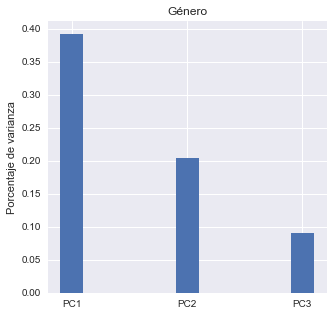

In [5]:
# plot for the gender subspace principal components
import matplotlib.pyplot as plt
print(var1)
fig = plt.figure(figsize = (5, 5))
values = ("PC1", "PC2", "PC3")
plt.style.use('seaborn')
plt.bar(values, var1, width = 0.2)
plt.ylabel("Porcentaje de varianza")
plt.title("Género")
plt.show()

In [6]:
femenine_words = ['abanderada', 'abogada', 'abonada', 'académica', 'acólita', 'acomodadora', 'acuñadora', 'adjunta', 'adversaria', 'aficionada', 'afiliada', 'agrimensora', 'alera', 'alevina',
                  'alineadora', 'amazona', 'andadora', 'animadora', 'anotadora', 'apoderada', 'apuntadora', 'árbitra', 'arquera', 'artillera', 'asesora', 'bateadora', 'bicampeona', 'bigoleadora',
                  'bloqueadora', 'bogadora', 'boleadora', 'boxeadora', 'buceadora', 'buza', 'cabeceadora', 'cancerbera', 'campeona', 'canoera', 'canterana', 'capitana', 'cazadora',
                  'cedida', 'cetrera', 'chazadora', 'chupona', 'chuteadora', 'clasificada', 'colegiada', 'colocadora', 'comisaria', 'companera', 'competidora', 'conductora', 'consejera', 'contadora',
                  'contraria', 'controladora', 'coordinadora', 'coreógrafa', 'corredora', 'cronoescaladora', 'cronometradora', 'cuidadora', 'defensora', 'delantera', 'delegada', 'deportiva', 'desfavorecida',
                  'desmarcada', 'directiva', 'directora', 'disenadora', 'dribladora', 'ejecutiva', 'ejecutora', 'empresaria', 'encargada', 'enemiga', 'entrenadora', 'disenadora', 'escaladora',
                  'escapada', 'esgrimidora', 'espectadora', 'esquiadora', 'expedicionaria', 'exploradora', 'extrema', 'fajadora', 'favorita', 'federada', 'federativa', 'enfermera', 'fisióloga',
                  'forofa', 'funámbula', 'galáctica', 'ganadora', 'garrochera', 'gerenta', 'gladiadora', 'goleadora', 'gregaria', 'guarnicionera', 'guerrera', 'haltera', 'halterófila', 'inspectora',
                  'instructora', 'intermediaria', 'interventora', 'jabata', 'jefa', 'jueza', 'jugadora', 'herida', 'heroína', 'herradora', 'lanzadora', 'lenera', 'lesionada', 'levantadora', 'líbera',
                  'limpiadora', 'luchadora', 'maestra', 'mandataria', 'marcadora', 'marchadora', 'mecánica', 'médica', 'medidora', 'mentora', 'monitora', 'monopatinadora', 'montanera', 'moza',
                  'nadadora', 'navegadora', 'notaria', 'novata', 'oficiala', 'olímpica', 'operadora', 'operaria', 'organizadora', 'paralímpica', 'pasadora', 'pasajera', 'patinadora', 'patrocinadora',
                  'patrona', 'pegadora', 'pelotera', 'pentacampeona', 'peona', 'percanterana', 'perdedora', 'perita' 'perseguidora', 'pescadora', 'pilota', 'piscinera', 'pistera', 'podóloga', 'portadora',
                  'porteadora', 'preparadora', 'presidenta', 'principianta', 'probadora', 'profesora', 'pseudoextrema', 'psicóloga', 'puntera', 'quinesióloga', 'pupila', 'realizadora',
                   'rebotadora', 'receptora', 'recogedora', 'recordwoman', 'regateadora', 'remadora', 'rematadora', 'remera', 'revendedora', 'rezagada', 'rodadora', 'sacadora', 'sacrificada', 'saltadora',
                   'secadora', 'secretaria', 'seguidora', 'seleccionadora', 'servidora', 'socia', 'soltadora', 'subalterna', 'subcampeona', 'surfera', 'sustituta', 'talonadora', 'tanteadora', 'teatrera',
                   'técnica', 'tiradora', 'todaterreno', 'trainera', 'traumatóloga', 'trazadora', 'trigoleadora', 'triunfadora', 'usuaria', 'utilera', 'vencedora', 'veterana', 'vicegerenta', 'vicelideresa',
                   'vicepresidenta', 'zaguera']

masculine_words = ['abanderado', 'abogado', 'abonado', 'académico', 'acólito', 'acomodador', 'acuñador', 'adjunto', 'adversario', 'aficionado', 'afiliado', 'agrimensor', 'alero', 'alevín',
                  'alineador', 'jinete', 'andador', 'animador', 'anotador', 'apoderado', 'apuntador', 'árbitro', 'arquero', 'artillero', 'asesor', 'bateador', 'bicampeón', 'bigoleador',
                  'bloqueador', 'bogador', 'boleador', 'boxeador', 'buceador', 'buzo', 'cabeceador', 'cancerbero', 'campeón', 'canoero', 'canterano', 'capitán', 'cazador', 
                  'cedido', 'cetrero', 'chazador', 'chupón', 'chuteador', 'clasificado', 'colegiado', 'colocador', 'comisario', 'companero', 'competidor', 'conductor', 'consejero', 'contador',
                  'contrario', 'controlador', 'coordinador', 'coreógrafo', 'corredor', 'cronoescalador', 'cronometrador', 'cuidador', 'defensor', 'delantero', 'delegado', 'deportivo', 
                  'desfavorecido','desmarcado', 'directivo', 'director', 'disenador', 'driblador', 'ejecutivo', 'ejecutor', 'empresario', 'encargado', 'enemigo', 'entrenador', 'disenador', 
                  'escalador','escapado', 'esgrimidor', 'espectador', 'esquiador', 'expedicionario', 'explorador', 'extremo', 'fajador', 'favorito', 'federado', 'federativo', 'enfermero', 'fisiólogo',
                  'forofo', 'funámbulo', 'galáctico', 'ganador', 'garrochero', 'gerente', 'gladiador', 'goleador', 'gregario', 'guarnicionero', 'guerrero', 'haltero', 'halterófilo', 'inspector',
                  'instructor', 'intermediario', 'interventor', 'jabato', 'jefe', 'juez', 'jugador', 'herido',  'héroe', 'herrador', 'lanzador', 'lenero', 'lesionado', 'levantador', 'líbero',
                  'limpiador', 'luchador', 'maestro', 'mandatario', 'marcador', 'marchador', 'mecánico', 'médico', 'medidor', 'mentor', 'monitor', 'monopatinador', 'montanero', 'mozo',
                  'nadador', 'navegador', 'notario', 'novato', 'oficial', 'olímpico', 'operador', 'operario', 'organizador', 'paralímpico', 'pasador', 'pasajero', 'patinador', 'patrocinador',
                  'patrón', 'pegador', 'pelotero', 'pentacampeón', 'peón', 'percanterano', 'perdedor', 'perito' 'perseguidor', 'pescador', 'piloto', 'piscinero', 'pistero', 'podólogo', 'portador',
                  'porteador', 'preparador', 'presidente', 'principiante', 'probador', 'profesor', 'pseudoextremo', 'psicólogo', 'puntero', 'quinesiólogo', 'pupilo', 'realizador',
                   'rebotador', 'receptor', 'recogedor', 'recordman', 'regateador', 'remador', 'rematador', 'remero','revendedor', 'rezagado', 'rodador', 'sacador', 'sacrificado', 'saltador',
                   'secador', 'secretario', 'seguidor', 'seleccionador', 'servidor', 'socio', 'soltador', 'subalterno', 'subcampeón', 'surfero', 'sustituto', 'talonador', 'tanteador', 'teatrero',
                   'técnico', 'tirador', 'todoterreno', 'trainero', 'traumatólogo', 'trazador', 'trigoleador', 'triunfador', 'usuario', 'utilero', 'vencedor', 'veterano', 'vicegerente', 'vicelíder',
                   'vicepreseidente', 'zaguero']

In [7]:
print(len(femenine_words))

print(len(masculine_words))

221
221


In [8]:
# preprocess the list of femenine words to see if it is in the vocab
c = 0
indexes = []
excluded_words_fem = []
excluded_words_masc = []
for i in range(len(femenine_words)):
    if femenine_words[i] in w2v_model.wv.index_to_key:
        c +=1
    if femenine_words[i] not in w2v_model.wv.index_to_key and i not in indexes:
        indexes.append(i)
        if masculine_words[i] in w2v_model.wv.index_to_key:
            print(masculine_words[i])
print("Femenine words: ",c)

c = 0
for i in range(len(masculine_words)):
    if masculine_words[i] in w2v_model.wv.index_to_key:
        c +=1
    if masculine_words[i] not in w2v_model.wv.index_to_key:
        if femenine_words[i] in w2v_model.wv.index_to_key:
            print(femenine_words[i])
        if i not in indexes:
            indexes.append(i)
print("Masculine words: ", c)

for index in sorted(indexes, reverse=True):
    del femenine_words[index]
    del masculine_words[index]

gender_pairs = []
for i in range(len(masculine_words)):
    gender_pairs.append([femenine_words[i], masculine_words[i]])

print(len(gender_pairs))

acólito
alero
alevín
alineador
apuntador
bateador
buzo
chupón
driblador
fajador
fisiólogo
funámbulo
gerente
interventor
herrador
lenero
oficial
peón
podólogo
principiante
probador
recogedor
todoterreno
trigoleador
utilero
Femenine words:  173
acomodadora
haltera
trainera
vicepresidenta
Masculine words:  194
169


In [9]:
# antes del algoritmo genético, seleccionar las 50 palabras que mas aparecen en el vocabulario
# para ello hago la media entre la variante femenina y la variante masculina

# Loading the tokenized data
import pickle
with open(PATH_VOCAB, "rb") as fp:   # Unpickling
    b = pickle.load(fp)

# dictionary contains the word counts
dictionary = {}
for article in b:
    for lemma in article:
        if lemma not in dictionary.keys():
            dictionary[lemma] = 1
        else:
            dictionary[lemma] += 1

# get mean of word freq in female and male words
freqs = [((dictionary[femenine_word]+dictionary[male_word])/2, femenine_word, male_word) for (femenine_word, male_word) in gender_pairs]
# sort in descending order
sorted_freqs = sorted(freqs, key=lambda x: x[0], reverse=True)

In [10]:
sorted_gender_pairs = []
for i in range(50):
    sorted_gender_pairs.append([sorted_freqs[i][1], sorted_freqs[i][2]])


In [11]:
print(sorted_gender_pairs)

[['jugadora', 'jugador'], ['técnica', 'técnico'], ['entrenadora', 'entrenador'], ['deportiva', 'deportivo'], ['campeona', 'campeón'], ['presidenta', 'presidente'], ['delantera', 'delantero'], ['directora', 'director'], ['ganadora', 'ganador'], ['marcadora', 'marcador'], ['companera', 'companero'], ['pilota', 'piloto'], ['capitana', 'capitán'], ['olímpica', 'olímpico'], ['cedida', 'cedido'], ['goleadora', 'goleador'], ['favorita', 'favorito'], ['extrema', 'extremo'], ['contraria', 'contrario'], ['seleccionadora', 'seleccionador'], ['árbitra', 'árbitro'], ['médica', 'médico'], ['jefa', 'jefe'], ['lesionada', 'lesionado'], ['encargada', 'encargado'], ['aficionada', 'aficionado'], ['clasificada', 'clasificado'], ['canterana', 'canterano'], ['directiva', 'directivo'], ['jueza', 'juez'], ['veterana', 'veterano'], ['conductora', 'conductor'], ['colegiada', 'colegiado'], ['corredora', 'corredor'], ['vencedora', 'vencedor'], ['preparadora', 'preparador'], ['empresaria', 'empresario'], ['abogada

## K-FOLDS Cross validation
Perform k-folds cross validation to observe the variance between the experiment. Each experiment takes a subset of paired words of the gender_pairs list and outputs the explained variance of the first principal component after performing PCA on that subset.

This analysis can have two possible outcomes:

1. If there's little standard deviation between the experiments, the method described in the baseline can be adequate, and it can be difficult to find a subset that explains the variance better. In this case, word choice does not affect the direction of the gender subspace as long as pairs of masculine and femenine words are chosen
2. If there's a considerate standard deviation between the experiments, the words in the baseline may not be adequate in this context of defining the gender subspace, and it may be interesting to find a method which selects the most relevant words in the list to define this direction in the context of Spanish Sport News

In [12]:
# K-FOLDS Cross Validation

''' Function that splits the data into k folds, returns a list with sublists
        Input: k (# ), gender_pairs (list)
        Output: experiments (list) '''
def get_k_folds(k, gender_pairs):
    # pick number of folds
    # copy the list of input
    input_data = gender_pairs.copy()
    # split the dataset into k equal parts
    experiments = []
    # randomize selection of data in the folds
    np.random.shuffle(input_data)
    input_data = list(input_data)

    for i in range(k-1):
        experiments.append(input_data[:round(len(gender_pairs)/k)]) 
        del input_data[:round(len(gender_pairs)/k)]
    if len(input_data) != 0:
        experiments.append(input_data)
    return experiments

'''Function that performs PCA on selected vectors
    Input: experiment (list of word pairs)
    Output: explained variance of the principal component'''
def calculate_pca(experiment):
    gender_v= [w2v_model.wv[pair[0]]-w2v_model.wv[pair[1]] for pair in experiment]
    standardized_v = StandardScaler().fit_transform(gender_v)
    pca = PCA(n_components=3)
    pca.fit(standardized_v)
    return pca.explained_variance_ratio_[0]


folds = [5, 10, 15, 20]
for k in folds:
    experiments = get_k_folds(k, gender_pairs)
    for experiment in experiments:
        
        results = []
        for experiment in experiments:
            results.append(calculate_pca(experiment))

    st_dev = np.std(results)
    mean = np.mean(results)
    print(st_dev, mean)
'''

experiments = get_k_folds(20, gender_pairs)
for experiment in experiments:
    
    results = []
    results.append(calculate_pca(experiment))
    print(len(experiment))
    print(experiment)

# plot for the gender subspace
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
values = []
for i in range(len(experiments)):
    values.append(str(i+1))
plt.bar(values, results, color = "blue", width = 0.2)
plt.ylabel("Porcentaje de varianza")
plt.title("Número de experimento")
plt.show()
'''



0.0198599995381839 0.13483025175200483
0.017141869779997074 0.16928380891504982
0.028917198558630144 0.22336525464133233
0.03909639461620407 0.26183877331244


'\n\nexperiments = get_k_folds(20, gender_pairs)\nfor experiment in experiments:\n    \n    results = []\n    results.append(calculate_pca(experiment))\n    print(len(experiment))\n    print(experiment)\n\n# plot for the gender subspace\nimport matplotlib.pyplot as plt\nfig = plt.figure(figsize = (5, 5))\nvalues = []\nfor i in range(len(experiments)):\n    values.append(str(i+1))\nplt.bar(values, results, color = "blue", width = 0.2)\nplt.ylabel("Porcentaje de varianza")\nplt.title("Número de experimento")\nplt.show()\n'

In [13]:
# antes del algoritmo genético, seleccionar las 50 palabras que mas aparecen en el vocabulario
# para ello hago la media entre la variante femenina y la variante masculina

# Loading the tokenized data
import pickle
with open(PATH_VOCAB, "rb") as fp:   # Unpickling
    b = pickle.load(fp)

# dictionary contains the word counts
dictionary = {}
for article in b:
    for lemma in article:
        if lemma not in dictionary.keys():
            dictionary[lemma] = 1
        else:
            dictionary[lemma] += 1

# get mean of word freq in female and male words
def get_word_frequencies(word_pairs):
    freqs = [((dictionary[femenine_word]+dictionary[male_word])/2, dictionary[femenine_word], dictionary[male_word], femenine_word, male_word) for (femenine_word, male_word) in word_pairs]
    sorted_freqs = sorted(freqs, key=lambda x: x[0], reverse=True)
    return sorted_freqs

In [14]:
ES_defs = [["mujer", "hombre"], ["nina", "nino"], ["ella", "él"], ["madre", "padre"], ["hija", "hijo"], ["chica", "chico"], 
           ["femenino", "masculino"], ["hermana", "hermano"], ["tía", "tío"], ["maría", "juan"], ["hembra", "macho"]]
sorted_freqs = get_word_frequencies(ES_defs)
print(sorted_freqs)

she_he_classifier(ES_defs)


[(35369.0, 20759, 49979, 'ella', 'él'), (12641.5, 10831, 14452, 'maría', 'juan'), (10670.0, 10943, 10397, 'mujer', 'hombre'), (10090.0, 9639, 10541, 'madre', 'padre'), (7650.0, 5889, 9411, 'hija', 'hijo'), (6107.5, 8907, 3308, 'femenino', 'masculino'), (3715.5, 2101, 5330, 'hermana', 'hermano'), (3657.0, 1921, 5393, 'nina', 'nino'), (2622.0, 1969, 3275, 'chica', 'chico'), (958.0, 419, 1497, 'tía', 'tío'), (57.0, 19, 95, 'hembra', 'macho')]
Word mujer captures gender: 0.81843215 0.48533824
Word hombre captures gender: 0.48533824 0.81843215
Word nina captures gender: 0.6707164 0.2993164
Word nino captures gender: 0.2993164 0.6707164
Word ella captures gender: 1.0 0.67664003
Word él captures gender: 0.67664003 1.0
Word madre captures gender: 0.81687236 0.5386227
Word padre captures gender: 0.5386227 0.81687236
Word hija captures gender: 0.7610728 0.41841397
Word hijo captures gender: 0.41841397 0.7610728
Word chica captures gender: 0.8000066 0.455199
Word chico captures gender: 0.455199 0

[('mujer', 'hombre'),
 ('nina', 'nino'),
 ('ella', 'él'),
 ('madre', 'padre'),
 ('hija', 'hijo'),
 ('chica', 'chico'),
 ('femenino', 'masculino'),
 ('hermana', 'hermano'),
 ('tía', 'tío'),
 ('maría', 'juan')]

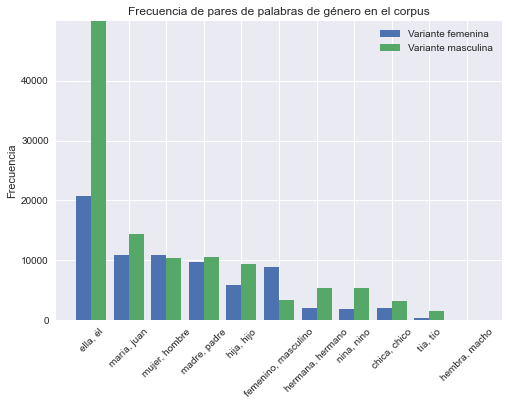

In [15]:
# plot sorted freqs
def plot_frequencies(arr):
    import matplotlib.pyplot as plt
    plt.style.use("seaborn")
    fem_words = [elem[1] for elem in arr]
    masc_words = [elem[2] for elem in arr]
    tags = [elem[3] + ", "+ elem[4]  for elem in arr]

    X_axis = np.arange(len(tags)) 
    ax=plt.gca()
    ax.set_ylim([0,max((max(fem_words), max(masc_words)))])
    plt.bar(X_axis - 0.2, fem_words, 0.4, label = 'Variante femenina') 
    plt.bar(X_axis + 0.2, masc_words, 0.4, label = 'Variante masculina')
    plt.xticks(X_axis, tags, rotation=45) 
    plt.ylabel("Frecuencia")
    plt.title("Frecuencia de pares de palabras de género en el corpus")
    plt.legend()
    plt.show()

plot_frequencies(sorted_freqs)

In [16]:
sorted_gender_pairs = []
for i in range(100):
    sorted_gender_pairs.append([sorted_freqs[i][1], sorted_freqs[i][2]])

folds = [5, 10, 20]
for k in folds:
    experiments = get_k_folds(k, sorted_gender_pairs)
    for experiment in experiments:
        
        results = []
        for experiment in experiments:
            results.append(calculate_pca(experiment))

    st_dev = np.std(results)
    mean = np.mean(results)
    print(st_dev, mean)

IndexError: list index out of range

[3.91978239e-01 2.04594945e-01 9.12305070e-02 8.54858158e-02
 7.40264203e-02 6.15163035e-02 5.41282687e-02 3.70395010e-02
 3.78546683e-33]


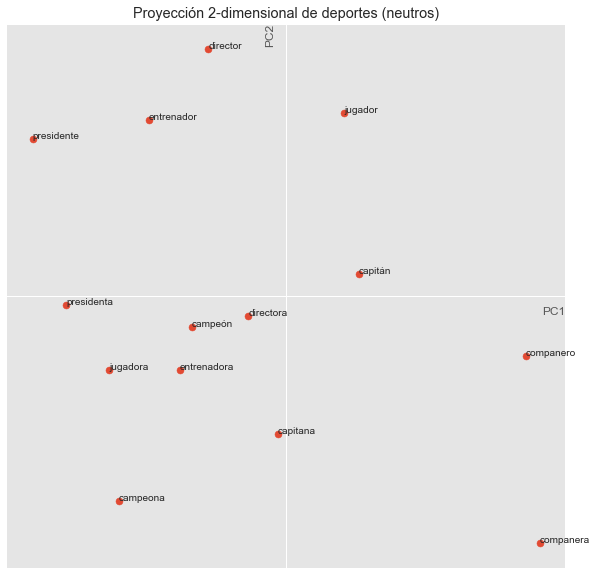

In [ ]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
# esto de aquí https://cienciadedatos.net/documentos/py19-pca-python

from sklearn.pipeline import make_pipeline
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(gender_v)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']
print(modelo_pca.explained_variance_ratio_)

# PALABRAS NEUTRAS: DEPORTES
#word_l = ["jugador", "jugadora", "ella", "él", "fútbol", "baloncesto", "tenis", "ciclismo", "gimnasia", "motociclismo", "automovilismo", "voleibol", "patinaje", "balonmano", "atletismo", "baile", "esquí", "golf", "hípica", "natación"]

# PALABRAS NEUTRAS: ADJETIVOS DEPORTISTAS
#word_l = ["jugador", "jugadora", "atleta", "futbolista", "baloncestista", "tenista", "ciclista", "gimnasta", "golfista", "deportista", "equipo"]

#PALABRAS CON GÉNERO
word_l = ["jugador", "jugadora", "entrenador", "entrenadora", "campeón", "campeona", "capitán", "capitana", "presidente", "presidenta", "director", "directora", "companero", "companera"]

# PALABRAS DE BOLUBASKI ET AL.
#word_l = ["él", "ella", "juego", "sujeto", "aspecto", "heno", "pelea", "identidad", "golosinas", "partes", "salón", "empresas", "escarcha", "muslos", "víctimas", "lujuria", "orden", "cartas", "regla", "buscando", "rosas", "pastel", "jarrones", "juventud", "alojamiento",  "nuclear", "divorcio", "récords", "táctico", "manualidades", "ultrasonido", "modelaje", "costura", "pendientes", "vaca", "frío", "firme", "gurú", "votantes", "efecto", "perlas", "pechos", "trimestre", "lectura", "compromiso", "lentitud", "llegada", "brillante", "yarda", "corbata", "barba", "regional", "segundos", "aceite", "vestido"]
words = [w2v_model.wv[word] for word in word_l]

# proyectar los datos y extraerlos
proyecciones = pca_pipe.transform(X=words)
x = [point[0] for point in proyecciones]
y = [point[1] for point in proyecciones]

# SCATTER PLOT
plt.style.use('ggplot')
fig= plt.figure(figsize=(10, 10))
plt.rcParams["figure.autolayout"] = True

# add cartesian coordinates & center them
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.grid(False)
ax.set_xlabel("PC1", loc='right')
ax.set_ylabel("PC2", loc= 'top')

# plot the points and add annotations
plt.scatter(x, y)
for i in range(len(word_l)):
    plt.text(x[i], y[i], word_l[i])

plt.title("Proyección 2-dimensional de deportes (neutros)")
plt.show()

# Gender Bias Metrics

In [22]:
#------------ DIRECT BIAS ------------

'''Input: 1 list with female words, 1 list with male words
   Output: gender vector
   Differenece of the centroid of the male - female vectors, final vector is normalized'''
def gender_subspace_centroids(female_w, male_w):
    vs = [sum(w2v_model.wv[word] for word in names) for names in (female_w, male_w)]
    vs = [v / np.linalg.norm(v) for v in vs]
    v_gender = vs[1] - vs[0]
    v_gender = v_gender / np.linalg.norm(v_gender)
    return v_gender

# PROYECTAR EXPERIMENTOS SOBRE VECTOR DE GÉNERO
'''Given a list of words (str), returns a list of tuples (word (str), projection on gender vector (float))'''
def create_projections(words, g):
    projection = []
    for w in words:
        word_v = w2v_model.wv[w]
        # normalizar
        normalized_w = word_v / np.linalg.norm(word_v)
        # proyección = producto escalar
        projection.append((normalized_w.dot(g), w))
    return sorted(projection)

'''Center the words'''
def center_words(projections):
    vectors = [w[0] for w in projections]
    mean = np.mean(vectors)
    return [w-mean for w in vectors]

# GENERATE AND APPLY EXPERIMENTS
# prepare list of words
female_w = [female_word for (female_word, male_word) in gender_pairs_filtered]
male_w= [male_word for (female_word, male_word) in gender_pairs_filtered]

# construct gender subspace
g = ES_gender_direction

exp1 = ["baloncesto", "rugby", "ciclismo", "motociclismo", "automovilismo", "atletismo", "natación", "fútbol", "tenis", "voleibol", "gimnasia", "boxeo", "balonmano", "patinaje"]
exp2 = ["partido", "equipo", "casa", "logro", "copa", "estadio", "pareja", "familia", "hogar", "cuidado", "relación", "sentimental"]
exp3 = ["fuerte", "valiente", "piernas", "inteligente", "brillante", "cuerpo", "modelo", "belleza", "labios", "sensual"]

def get_word_frequencies(words):
    freqs = [(dictionary[word], word) for word in words]
    sorted_freqs = sorted(freqs, key=lambda x: x[0], reverse=True)
    return sorted_freqs

print("Word frequencies")
print(get_word_frequencies(exp1))
print(get_word_frequencies(exp2))
print(get_word_frequencies(exp3))

proj1 = create_projections(exp1, g)
res1 = center_words(proj1)

proj2 = create_projections(exp2, g)
res2 = center_words(proj2)

proj3 = create_projections(exp3, g)
res3 = center_words(proj3)

Word frequencies
[(53970, 'fútbol'), (9129, 'baloncesto'), (8625, 'tenis'), (4692, 'ciclismo'), (3318, 'rugby'), (3008, 'boxeo'), (2467, 'atletismo'), (1623, 'balonmano'), (1355, 'natación'), (679, 'automovilismo'), (674, 'gimnasia'), (577, 'voleibol'), (569, 'motociclismo'), (398, 'patinaje')]
[(153933, 'equipo'), (128840, 'partido'), (34029, 'copa'), (32343, 'casa'), (18022, 'estadio'), (16679, 'relación'), (15867, 'familia'), (13095, 'pareja'), (2586, 'cuidado'), (1899, 'hogar'), (834, 'logro'), (772, 'sentimental')]
[(11606, 'cuerpo'), (11057, 'fuerte'), (10052, 'modelo'), (3123, 'piernas'), (2682, 'brillante'), (2120, 'inteligente'), (1339, 'belleza'), (1059, 'valiente'), (463, 'labios'), (216, 'sensual')]


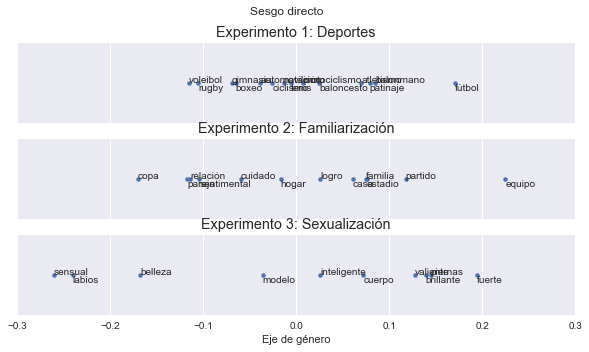

In [23]:
# PLOT DIRECT BIAS
'''functions to show data in a semicircle (less packed). Optional'''
def generate_points(radius, x_points):
    y_points = [np.sqrt(np.square(radius)-np.square(x)) for x in x_points]
    annotations = [x[0] for x in sp]
    return x_points, y_points, annotations

def generate_semicircle(radius):
    x_points = [i for i in range(-8,9)]
    y_points = [np.sqrt(np.square(radius)-np.square(x)) for x in x_points]
    return x_points, y_points

# MATPLOTLIB GRAPH REPRESENTATION
# generate 3 subplots
fig, axs = plt.subplots(3, sharex=True)
fig.set_size_inches(10, 5)
plt.style.use('ggplot')
fig.suptitle("Sesgo directo")

# plot results from experiment 1
axs[0].scatter(res1, [0]*len(res1), s=15)
for i in range(len(proj1)):
    if i%2 == 0:
        axs[0].text(res1[i], 0, proj1[i][1])
    else:
        axs[0].text(res1[i], - 0.011, proj1[i][1])

# plot results from experiment 2
axs[1].scatter(res2, [0]*len(res2), s=15)
for i in range(len(proj2)):
    if i%2 == 0:
        axs[1].text(res2[i], 0, proj2[i][1])
    else:
        axs[1].text(res2[i], - 0.011, proj2[i][1])

# plot results from experiment 3
axs[2].scatter(res3, [0]*len(res3), s=15)
for i in range(len(proj3)):
    if i%2 == 0:
        axs[2].text(res3[i], 0, proj3[i][1])
    else:
        axs[2].text(res3[i], - 0.011, proj3[i][1])

# set titles of the experiment
axs[0].set_title("Experimento 1: Deportes")
axs[1].set_title("Experimento 2: Familiarización")
axs[2].set_title("Experimento 3: Sexualización")
# set x axis label
axs[2].set_xlabel("Eje de género")
#axs.set_aspect('equal')
for i in range(3):
    axs[i].set_xlim(-0.3,0.3)
    axs[i].set_yticks([])

plt.show()


In [7]:
#------------ WEAT SCORE ------------
''' Conjuntos de palabras objetivo neutras (hipothesis):
    - X: anticipa sesgo hacia A
    - Y: anticipa sesgo hacia B
    
    Conjuntos sesgados:
    - A: sesgo masculino
    - B: sesgo femenino
     
    Interpretación de los resultados:
     Valor positivo indica que las palabras de X se inclinan hacia A y las
     palabras de Y se inclinan hacia B -> se confirma sesgo ''' 
    
set_A = [ male_word for (female_word, male_word) in ES_defs_trunc]
set_B = [ female_word for (female_word, male_word) in ES_defs_trunc]

''' calculates s(w,A,B) for each w in X or Y'''
def word_individual_bias(word, A, B):
    n = len(A)
    b1 = 0
    b2 = 0
    for w in A:
        b1 += w2v_model.wv.similarity(word, w)
    for w in B:
        b2 += w2v_model.wv.similarity(word, w)
    return (1/n) * b1 - (1/n) * b2

''' calculates s(w, A, B) in gendered words'''
def individual_bias_gender(word_f, word_m, A, B):
    return abs((abs(word_individual_bias(word_m, A, B))-abs(word_individual_bias(word_f, A, B))))

''' computes WEAT score for gendered languages given sets X, Y, A, B'''
def weat_score_gender(X, Y, A, B):
    resX = []
    resY = []

    for word in X:
        if isinstance(word, str):
            b = abs(word_individual_bias(word, A, B))
            print(word+ ": "+ str(b))
            resX.append(b)
        if isinstance(word, tuple):
            (f_w, m_w) = word
            b = individual_bias_gender(f_w, m_w, A, B)
            print(str(word) + ": "+ str(b))
            resX.append(b)

    for word in Y:
        if isinstance(word,str):
            resY.append(abs(word_individual_bias(word, A, B)))
        if isinstance(word, tuple):
            (f_w, m_w) = word
            b = individual_bias_gender(f_w, m_w, A, B)
            print(str(word) + ": "+ str(b))
            resY.append(b)
    return sum(resX) - sum(resY)
    #return (np.mean(resX)-np.mean(resY)) / np.std(resX+resY)

''' Computes weat score given sets X, Y, A, B'''
def weat_score(X, Y, A, B):
    resX = [word_individual_bias(word, A, B) for word in X]
    resY = [word_individual_bias(word, A, B) for word in Y]
    return sum(resX) - sum(resY)  # segun un vid de youtube este es el weat SCORE https://www.youtube.com/watch?v=eTenkUPsjko&ab_channel=AIAnytime
    #return (np.mean(resX)-np.mean(resY)) / np.std(resX+resY)



In [8]:
'''Experiment building'''
exp = []
# EXPERIMENTO 1: deportes
set_X = ["fútbol", "baloncesto", "rugby", "ciclismo", "motociclismo", "automovilismo", "boxeo"]
set_Y = ["tenis", "voleibol", "natación", "atletismo", "gimnasia", "patinaje"]
exp.append((set_X, set_Y))
# EXPERIMENTO 2: familiarización
set_X = ["partido", "equipo", "casa", "logro", "copa", "estadio"]
set_Y = ["pareja", "familia", "hogar", "cuidado", "relación", "sentimental"]
exp.append((set_X, set_Y))
# EXPERIMENTO 3: sexualización
set_X = ["fuerte", "valiente", "piernas", "inteligente", "brillante"]
set_Y = ["cuerpo", "modelo", "belleza", "labios", "sensual", "sentimental"]
exp.append((set_X, set_Y))

"""WEAT neutro"""
for (x,y) in exp:
    print("------------------")
    print(weat_score(x,y,set_A,set_B))


------------------
0.49873496987856925
------------------
1.0121291769965968
------------------
1.1531236474531599


### WEAT statistical significance

In [9]:
# get all permutations possible by combining list of "female" and "male" hypothetical
# lists of the experiments
import itertools
import random

exp2_x = exp[1][0] 
exp2_y = exp[1][1]
mixed_sets = exp2_x + exp2_y

permutations_exp1 = list(itertools.permutations(mixed_sets,6))
random.shuffle(permutations_exp1)
weat_score_base = weat_score(exp2_x, exp2_y, set_A, set_B)


In [10]:
'''count_p_test = 0

for i in range(len(permutations_exp1) // 2, 2):
    print(i)
    e1 = permutations_exp1[i]
    e2 = permutations_exp1[i+1]
    # if weat_score is greater than calculated weat (mal asunto, ahí es cuando se cuenta)
    if weat_score_base < weat_score(e1, e2, set_A, set_B):
        count_p_test += 1
'''

p_test = []
for i in range(len(permutations_exp1) // 3, 2):
    print(i)
    e1 = permutations_exp1[i]
    print(e1)
    e2 = permutations_exp1[i+1]
    print(e2)
    # if weat_score is greater than calculated weat (mal asunto, ahí es cuando se cuenta)
    p_test.append(weat_score(tuple(e1), tuple(e2), set_A, set_B))
        


In [11]:
p_test

[]

In [ ]:
"""WEAT gramatical"""
exp = []
# EXPERIMENTO 1.1: deportes
set_X = ["futbolista", "baloncestista", "ciclista", ("pilota", "piloto"), ("conductora", "conductor"), ("boxeadora", "boxeador")]
set_Y = ["tenista", ("nadadora", "nadador"), "atleta", ("corredora", "corredor"), "gimnasta", ("patinadora", "patinador")]
exp.append((set_X, set_Y))
# EXPERIMENTO 2.1: familiarización
set_X = ["equipo", ("companero", "companera"), ("jugador", "jugadora"), ("entrenador", "entrenadora"), "estadio", ("ganador", "ganadora") ]
set_Y = [("novio", "novia"), ("hijo", "hija"), ("madre", "padre"), ("cuidadora", "cuidador"), "sentimental", "relación"]
exp.append((set_X, set_Y))
# EXPERIMENTO 3.1: sexualización
set_X = ["fuerte", "valiente", "brillante", "perseverante", ("listo", "lista")]
set_Y = ["sexy", "sensual", ("guapa", "guapo"), "modelo", ("bella", "bello")]
exp.append((set_X, set_Y))

for (x,y) in exp:
    print("------------------")
    print(weat_score_gender(x,y,set_A,set_B))


In [ ]:
#------------ SAME ------------
# los conjuntos A y B son los mismos que el subespacio de género
set_A = [ male_word for (female_word, male_word) in ES_defs_trunc]
set_B = [ female_word for (female_word, male_word) in ES_defs_trunc]

def normalize_set(x):
    x = [w2v_model.wv[w] / np.linalg.norm(w2v_model.wv[w]) for w in x]
    return x

def individual_bias_SAME(w, A, B):
    a_i =  (1/len(A)) * sum(A)
    b_i =  (1/len(B)) * sum(B)
    
    normalize_w = w2v_model.wv[w] / np.linalg.norm(w2v_model.wv[w])
    denominator = a_i - b_i
    denominator = denominator / np.linalg.norm(denominator)

    return abs(np.dot(normalize_w, denominator))

def metric_SAME(W, A, B):
    individual_bias = []
    A = normalize_set(A)
    B = normalize_set(B)
    res = 0
    # take mean absolute of individual bias
    for word in W:
        res += individual_bias_SAME(word, A, B)
        individual_bias.append((word, individual_bias_SAME(word, A, B)))
    return individual_bias, (1 / len(W)) * res

W= ["fútbol", "deportista", "copa"]
#W = ["mujer", "ella"]
b = metric_SAME(W, set_A, set_B)
print(b)

exp1 = ["baloncesto", "rugby", "ciclismo", "motociclismo", "automovilismo", "atletismo", "natación", "fútbol", "tenis", "voleibol", "gimnasia", "boxeo", "balonmano", "patinaje"]
exp2 = ["partido", "equipo", "casa", "logro", "copa", "estadio", "pareja", "familia", "hogar", "cuidado", "relación", "sentimental"]
exp3 = ["fuerte", "valiente", "piernas", "inteligente", "brillante", "cuerpo", "modelo", "belleza", "labios", "sensual"]

experiments = [exp1, exp2, exp3]
for exp in experiments:
    print(metric_SAME(exp, set_A, set_B))


([('fútbol', 0.2376204), ('deportista', 0.08083989), ('copa', 0.09083506)], 0.136431780954202)
([('baloncesto', 0.10790712), ('rugby', 0.09258339), ('ciclismo', 0.009805535), ('motociclismo', 0.015967777), ('automovilismo', 0.07503335), ('atletismo', 0.020072), ('natación', 0.23599501), ('fútbol', 0.2376204), ('tenis', 0.062025055), ('voleibol', 0.026822053), ('gimnasia', 0.22972316), ('boxeo', 0.040131625), ('balonmano', 0.09992), ('patinaje', 0.13474895)], 0.099168243751462)
([('partido', 0.24853584), ('equipo', 0.3576511), ('casa', 0.008149445), ('logro', 0.116635025), ('copa', 0.09083506), ('estadio', 0.12303391), ('pareja', 0.26022843), ('familia', 0.13855937), ('hogar', 0.26356852), ('cuidado', 0.026454926), ('relación', 0.053144302), ('sentimental', 0.21316838)], 0.15833036011705795)
([('fuerte', 0.15014297), ('valiente', 0.12058263), ('piernas', 0.005441329), ('inteligente', 0.17447436), ('brillante', 0.22249861), ('cuerpo', 0.0096573895), ('modelo', 0.16793495), ('belleza', 0.

# Examining Gender Bias in Languages with Grammatical Gender
https://github.com/shaoxia57/Bias_in_Gendered_Languages/blob/master/bias_emnlp19.ipynb

[3.9378452e-01 1.8310459e-01 1.0268822e-01 8.2557611e-02 8.0200478e-02
 6.6158898e-02 5.2726042e-02 3.8779665e-02 7.1460045e-15]


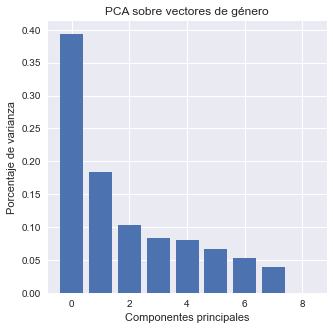

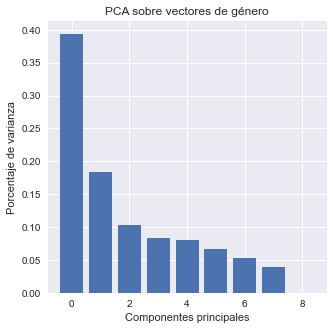

In [2]:
from sklearn.decomposition import PCA
import io

'''Return word vector (normalized). If OOV, return empty list'''
def get_vector(word):
    try:
        return w2v_model.wv[word] / np.linalg.norm(w2v_model.wv[word])
    except:
        return []

'''Perform PCA on gender vectors. Shows results in a bar plot. Returns PCA'''
def doPCA(pairs, num_components = 10):
    matrix = []
    for a, b in pairs:
        center = (get_vector(a) + get_vector(b)) / 2
        matrix.append(get_vector(a) - center)
        matrix.append(get_vector(b) - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    fig = plt.figure(figsize = (5, 5))
    plt.style.use('seaborn')
    plt.ylabel("Porcentaje de varianza")
    plt.xlabel("Componentes principales")
    plt.title("PCA sobre vectores de género")
    plt.bar(range(num_components), pca.explained_variance_ratio_)
    return pca

def doPCA_differences(pairs, num_components = 9):
    matrix = []
    for a, b in pairs:
        center = (get_vector(a) + get_vector(b)) / 2
        female = get_vector(a) - center
        male = get_vector(b) - center
        matrix.append(female - male)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    fig = plt.figure(figsize = (5, 5))
    plt.style.use('seaborn')
    plt.ylabel("Porcentaje de varianza")
    plt.xlabel("Componentes principales")
    plt.title("PCA sobre vectores de género")
    plt.bar(range(num_components), pca.explained_variance_ratio_)
    return pca

def doPCA_centroids(pairs, num_components = 2):
    matrix = []
    female_sum = np.zeros(100)
    male_sum = np.zeros(100)
    center = np.zeros(100)
    for a,b in pairs:
        female_sum += get_vector(a)
        male_sum += get_vector(b)
        center += (male_sum + female_sum) / 2
    matrix.append(female_sum - center)
    matrix.append(male_sum - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    return pca

# GENDER DEFINITIONAL PAIRS AS IN ZHOU ET AL.
ES_defs = [["mujer", "hombre"], ["nina", "nino"], ["ella", "él"], ["madre", "padre"], ["hija", "hijo"], ["chica", "chico"], ["femenino", "masculino"], ["hermana", "hermano"], ["maría", "juan"]]
ES_gender_direction = doPCA_differences(ES_defs).components_[0]
print(doPCA_differences(ES_defs).explained_variance_ratio_)

# Get Grammatical and Semantic Gender Directions

In [4]:
'''Read files with masculine and femenine words. Keep the words in vocabulary. Generate gender pairs'''
ES_masculine_nouns = []
ES_femenine_nouns = []

with open("./masculine_nouns_es", "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        vector = get_vector(word)
        if word not in ES_masculine_nouns and vector != [] :
            ES_masculine_nouns.append(word)

with open("./femenine_nouns_es", "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        vector = get_vector(word)
        if word not in ES_femenine_nouns and vector != []:
            ES_femenine_nouns.append(word)

print(len(ES_femenine_nouns))
print(len(ES_masculine_nouns))


ES_grammar_pair_new = []
for f,m in zip(ES_femenine_nouns, ES_masculine_nouns):
    pair = [f,m]
    print(pair)
    ES_grammar_pair_new.append(pair)
    
len(ES_grammar_pair_new)

c:\Users\marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':
c:\Users\marta\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


5705
4019
['espera', 'período']
['unión', 'viernes']
['prensa', 'tema']
['televisión', 'curso']
['extremadamente', 'parlamento']
['asamblea', 'artículo']
['inadmisibilidad', 'jueves']
['ejecución', 'apartado']
['pena', 'principio']
['posición', 'informe']
['comunidad', 'nombre']
['institución', 'sr']
['facultad', 'prestigio']
['condena', 'presidente']
['línea', 'gobernador']
['atención', 'caso']
['información', 'tribunal']
['base', 'acceso']
['reunión', 'medio']
['legislación', 'fiscal']
['cumplamos', 'número']
['razón', 'orden']
['junta', 'miércoles']
['sra', 'problema']
['vicepresidenta', 'diario']
['intervención', 'descontento']
['decisión', 'deseo']
['inmensa', 'riesgo']
['situación', 'futuro']
['ue', 'proyecto']
['gente', 'monopolio']
['conferencia', 'plazo']
['comisión', 'programa']
['reforma', 'discurso']
['petición', 'grupo']
['presentación', 'derecho']
['legislatura', 'máximo']
['unanimidad', 'mes']
['aceptación', 'impuesto']
['medida', 'voto']
['iniciativa', 'consejo']
['acti

4019

In [5]:
'''Gramatical gender direction with PCA. Take centroids from femenine & masculine grammatical words (ES_grammar_pair_new)'''
from numpy.linalg import norm
def cos_sim(emb1, emb2):
    return((emb1/np.linalg.norm(emb1)).dot(emb2/np.linalg.norm(emb2)))

def doPCA_gramatical(pairs, num_components = 2):
    matrix = []
    female_sum = np.zeros(100)
    male_sum = np.zeros(100)
    center = np.zeros(100)
    for a,b in pairs:
        female_sum += get_vector(a)
        male_sum += get_vector(b)
        center += (female_sum + male_sum) / 2
    matrix.append(female_sum - center)
    matrix.append(male_sum - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    return pca

ES_grammar_gender_direction_new = doPCA_gramatical(ES_grammar_pair_new).components_[0]

print("Grammar direction PCA: "+str(doPCA_gramatical(ES_grammar_pair_new).explained_variance_ratio_))

print("Cosine similarity between gender direction (definitional pairs) and grammatical direction: " +str(cos_sim(ES_grammar_gender_direction_new, ES_gender_direction)))

Grammar direction PCA: [1.00000000e+00 1.03996356e-25]
Cosine similarity between gender direction (definitional pairs) and grammatical direction: -0.15994176885308078


# Train a classifier to get the grammatical gender direction

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

shortened_3000 = ES_grammar_pair_new[:3000]

X_3000 = np.zeros((6000, 100))
counter = 0
for pair in shortened_3000:
    X_3000[counter] = get_vector(pair[0])
    counter +=1
    X_3000[counter] = get_vector(pair[1])
    counter += 1

y_3000 = np.tile([1, 2], 3000)

clf_LDA = LinearDiscriminantAnalysis(n_components=1)
scores_3000 = cross_val_score(clf_LDA, X_3000, y_3000, cv=5)
print("Accuracy: %0.4f (+/- %0.5f)" % (scores_3000.mean(), scores_3000.std() * 2))

clf_LDA.fit(X_3000, y_3000)

coef = clf_LDA.coef_
ES_grammar_gender_direction_3000 = np.reshape(coef/np.linalg.norm(coef), (100,))

print(ES_grammar_gender_direction_3000)

#Accuracy: 0.8063 (+/- 0.09898)

c:\Users\marta\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
c:\Users\marta\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review

Accuracy: 0.8062 (+/- 0.10404)
[-0.02097963 -0.20545261 -0.09174184 -0.01502311 -0.09143795 -0.01665487
 -0.02947417 -0.00619119 -0.12372624 -0.02071397  0.04358337 -0.0318628
 -0.06404734  0.03827029  0.12557924  0.06620914  0.022076   -0.09024278
  0.06555416 -0.00744386 -0.08755823 -0.16731766 -0.14850942 -0.08514929
 -0.01124691 -0.12677887 -0.15261228 -0.01457858 -0.01297444  0.00578908
 -0.13671628  0.23661089  0.20732164 -0.12406884 -0.05765483  0.11939421
 -0.01752004 -0.01653999  0.12626259 -0.0676684   0.00784604  0.16374145
 -0.09006356  0.08430841  0.18514192 -0.05555728  0.11184124  0.13195182
 -0.00025654  0.17322482 -0.06631585  0.0936106   0.24578037  0.06451577
  0.01060393  0.16897189  0.13223895  0.02317589 -0.11221013  0.13968678
 -0.05230241 -0.0854401   0.11015095 -0.06756645 -0.1270072  -0.03529004
 -0.10547047 -0.11482981  0.01242969  0.15533728  0.01523454  0.01590438
 -0.12462844 -0.03638727 -0.00568719  0.10567802 -0.04342066 -0.01051524
 -0.198425   -0.07460

In [7]:
cos_sim(ES_grammar_gender_direction_3000, ES_gender_direction)

0.19533273885895877

# Semantic gender directions

In [8]:
# Semantic Gender Directions
from numpy import linalg as LA
def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

# Get semantic gender component for a vector by removing the grammatical gender component
# vector - prod escalar(vector, ggd) * ggd/longitud(ggd)^2 (así serán perpendiculares)
def get_SG_component(vector, ggd):
    return vector - (vector.dot(ggd)*ggd/ggd.dot(ggd))

# get only the semantic meaning of gender
ES_semantic_gender_direction_LDA = get_SG_component(ES_gender_direction, ES_grammar_gender_direction_3000)

# cosine similarity between the semantic gender direction with LDA and the definitional pair direction with PCA
cos_sim(ES_semantic_gender_direction_LDA, ES_gender_direction)

0.9807370626846238

# Visualization

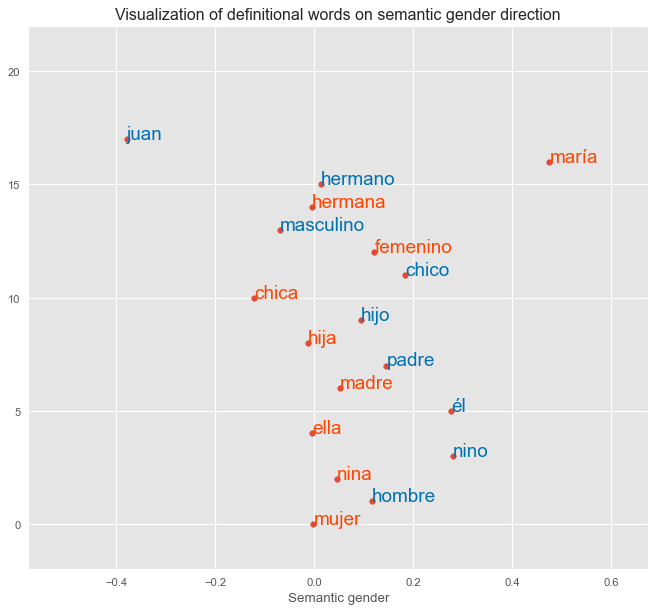

In [9]:
'''Plot pairs of words and color them depending on their grammatical gender'''
def plot_on_gender_dir_pairs(pairs, gender_direction, title="", x_label=""): 
    x_coords = []
    y_coords = list(range(len(pairs)*2))
    word_labels = []
    for pair in pairs:
        v0 = get_vector(pair[0])
        x_coords.append(v0.dot(gender_direction))
        word_labels.append(pair[0])
        v1 = get_vector(pair[1])
        x_coords.append(v1.dot(gender_direction))
        word_labels.append(pair[1])
    # display scatter plot
    plt.style.use('ggplot')

    fig=plt.figure(figsize=(10, 9), dpi=80)
    plt.scatter(x_coords, y_coords, s = 25)

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = "orangered" if k%2==0 else '#0072B2'  # masculine words in blue / feminine words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=17,
                     color=color)

    plt.xlim(min(x_coords) - 0.2, max(x_coords) + 0.2)
    plt.ylim(0 - 2, 20 + 2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()
    #fig.savefig('Occupation_on_gender_direction')

'''Plot neutral words without changing the color'''
def plot_words(words, gender_direction, title="", x_label=""):
    x_coords = []
    y_coords = list(range(len(words)))
    word_labels = []
    for word in words:
        v = get_vector(word)
        w = v.dot(gender_direction)
        x_coords.append(w)
        word_labels.append(word)
    plt.style.use('ggplot')

    fig=plt.figure(figsize=(10, 9), dpi=90)
    plt.scatter(x_coords, y_coords, s = 25)

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        plt.annotate(label, xy = (x,y), xytext = (0,0), textcoords='offset points', fontsize=15)
    plt.xlim(min(x_coords) - 0.2, max(x_coords) + 0.2)
    plt.ylim(0 - 2, 35 + 2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

plot_on_gender_dir_pairs(ES_defs, ES_semantic_gender_direction_LDA, 'Visualization of definitional words on semantic gender direction', "Semantic gender")

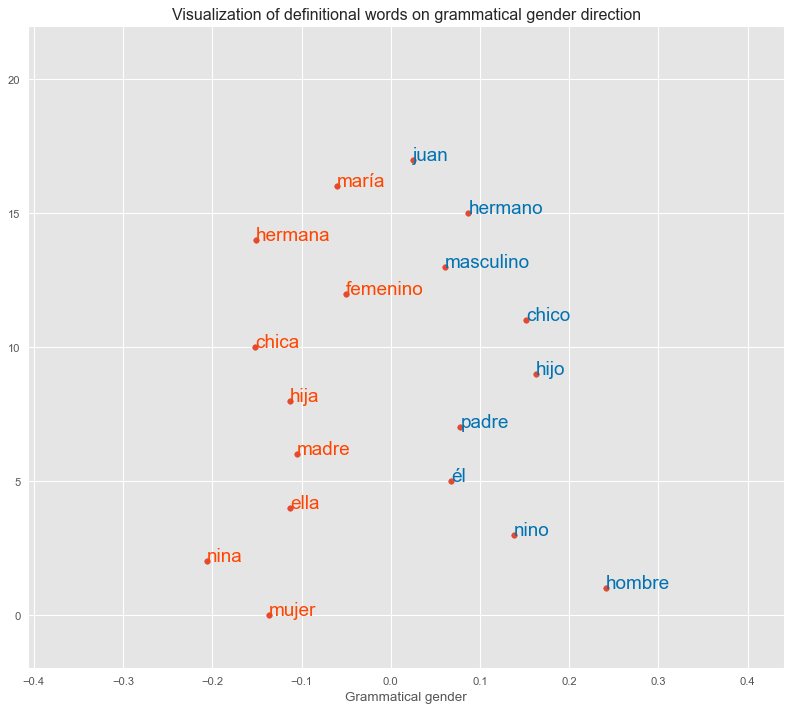

In [ ]:
plot_on_gender_dir_pairs(ES_defs, ES_grammar_gender_direction_3000, 'Visualization of definitional words on grammatical gender direction', "Grammatical gender")

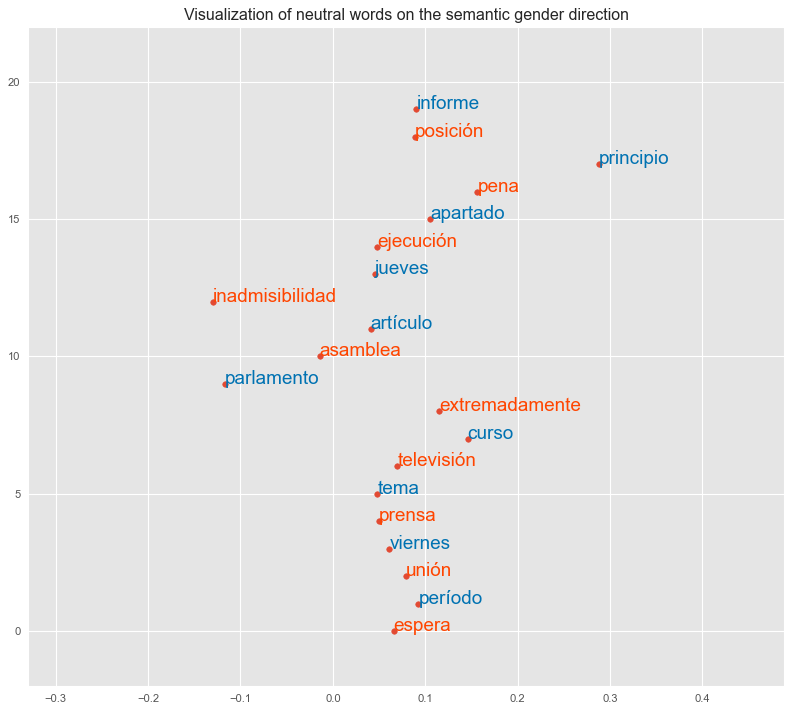

In [ ]:
plot_on_gender_dir_pairs(ES_grammar_pair_new[:10], ES_semantic_gender_direction_LDA, "Visualization of neutral words on the semantic gender direction")


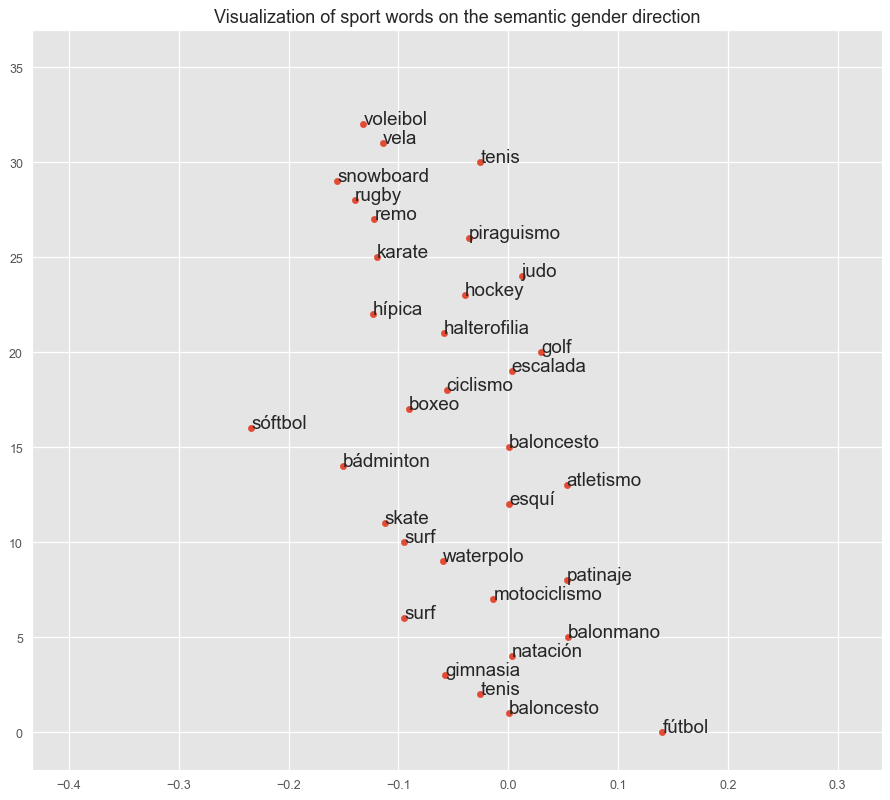

In [ ]:
list_sports = ["fútbol", "baloncesto", "tenis", "gimnasia", "natación", "balonmano", "surf", "motociclismo", "patinaje", "waterpolo", "surf", "skate", "esquí", "atletismo", "bádminton", "baloncesto", "sóftbol",
               "boxeo", "ciclismo", "escalada", "golf", "halterofilia", "hípica", "hockey", "judo", "karate", "piraguismo", "remo", "rugby", "snowboard", "tenis", "vela", "voleibol"]
#"halterofilia", "hípica", "hockey", "judo", "karate"
plot_words(list_sports, ES_semantic_gender_direction_LDA, "Visualization of sport words on the semantic gender direction")


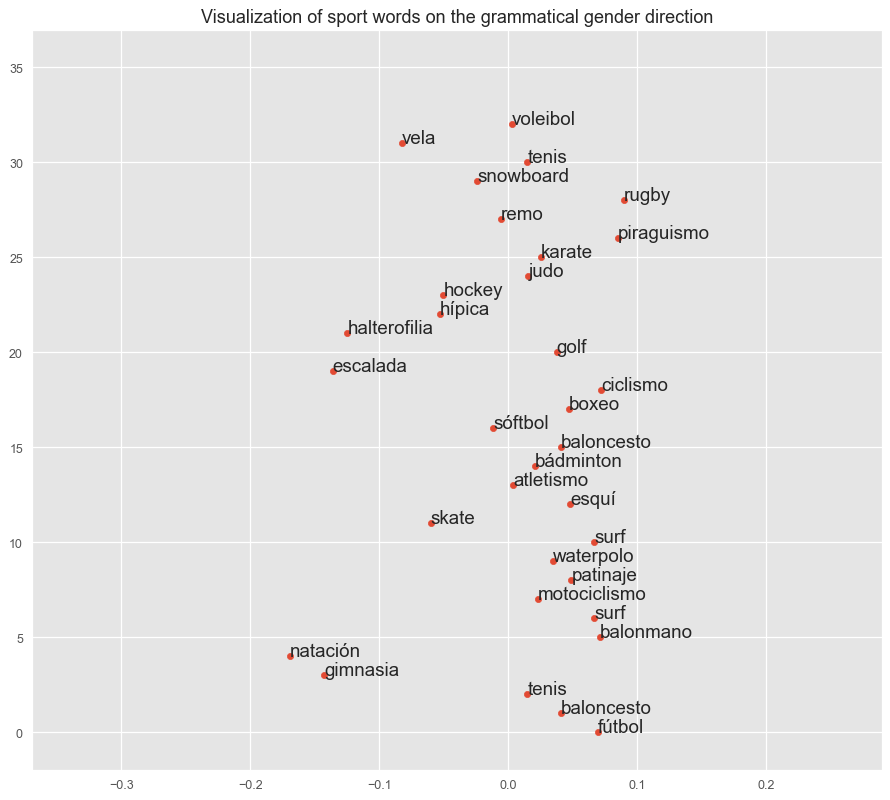

In [ ]:
plot_words(list_sports, ES_grammar_gender_direction_3000, "Visualization of sport words on the grammatical gender direction")


# PLOT on both gender and grammatical directions

In [21]:
def plot_on_both_dir_pairs(pairs, gender_direction, grammatical_gender_direction):
    x_coords = []
    y_coords = []
    word_labels = []
    counter = 0
    for pair in pairs:
        f_word = pair[0].split('(')[0]
        print(f_word)
        m_word = pair[1].split('(')[0]
        print(m_word)
        x_coords.append(get_vector(f_word).dot(gender_direction))
        y_coords.append(get_vector(f_word).dot(grammatical_gender_direction))
        word_labels.append(pair[0])
        x_coords.append(get_vector(m_word).dot(gender_direction))
        y_coords.append(get_vector(m_word).dot(grammatical_gender_direction))
        word_labels.append(pair[1])
    # display scatter plot
    fig=plt.figure(figsize=(14, 10), dpi=80)
    plt.scatter(x_coords, y_coords, s=20)

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'orangered' if k%2==0 else '#0072B2'  # masculine words in blue / feminine words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=13,
                     color=color)
    
    plt.xlim(min(x_coords) - 0.05, max(x_coords) + 0.2)
    plt.ylim(min(y_coords) - 0.1, max(y_coords) + 0.05)

    plt.xlabel('Semantic Gender Direction', fontsize=15)
    plt.ylabel('Grammatical Gender Direction', fontsize=15)

    plt.show()
'''
ES_plot_pairs = [['mujer', 'hombre'], ['jugadora', 'jugador'], \
                ['presidenta', 'presidente'], ['corredora', 'corredor'], ['novia', 'novio'], \
                 ['cuchara','cuchillo'],['agua','luz'], ["casa", "hogar"]]
'''

'''ES_plot_pairs = [['mujer', 'hombre'], ['maría', 'juan'], \
                ['chica', 'chico'], ['femenino', 'masculino'], ['ella', 'él'], \
                 ['hermana','hermano'],['tía','tío']]'''

ES_plot_pairs = [["fútbol", "baloncesto"], ["tenis", "gimnasia"], ["natación", "balonmano"], ["surf", "motociclismo"], ["patinaje", "waterpolo"], ["surf", "skate"], ["esquí", "atletismo"], ["bádminton", "baloncesto"], ["sóftbol",
               "boxeo"], ["ciclismo", "escalada"], ["golf", "halterofilia"], ["hípica", "hockey"], ["judo", "karate"], ["piraguismo", "remo"], ["rugby", "snowboard"], ["tenis", "vela"]]

fútbol
baloncesto
tenis
gimnasia
natación
balonmano
surf
motociclismo
patinaje
waterpolo
surf
skate
esquí
atletismo
bádminton
baloncesto
sóftbol
boxeo
ciclismo
escalada
golf
halterofilia
hípica
hockey
judo
karate
piraguismo
remo
rugby
snowboard
tenis
vela


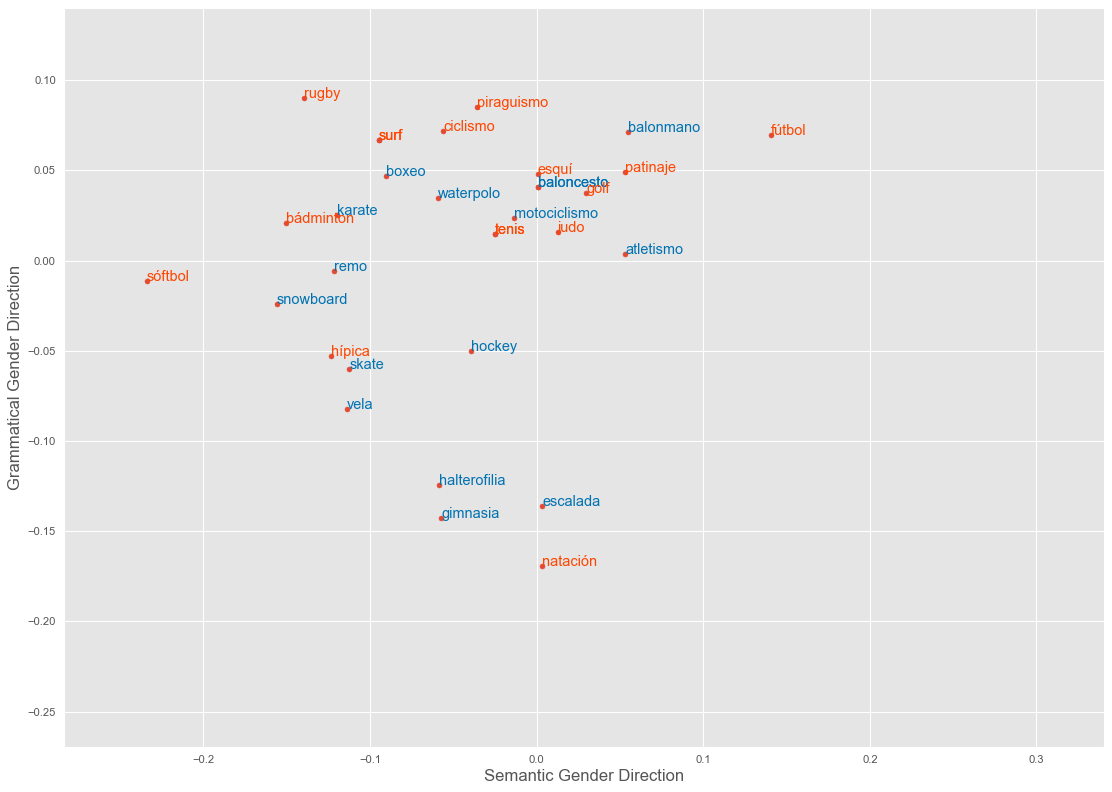

In [ ]:
plot_on_both_dir_pairs(ES_plot_pairs, ES_semantic_gender_direction_LDA, ES_grammar_gender_direction_3000)